In [1]:
from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py

from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.cells.activecell import ActiveCell
from cell_inference.cells.passivecell import PassiveCell
from cell_inference.cells.simulation import Simulation
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.config import paths, params
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

cell_type = CellTypes.ACTIVE

h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD,index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

In [2]:
rng = np.random.default_rng(12345)

inf_list = ['r_s', 'l_t', 'r_t']
number_samples = 2

xs = np.full((number_samples,1), 0.) if 'xs' not in inf_list else rng.uniform(low=-50, high=50, size=(number_samples,1))
ys = np.full((number_samples,1), 0.) if 'ys' not in inf_list else rng.uniform(low=-2000, high=5000, size=(number_samples,1))
zs = np.full((number_samples,1), 50.) if 'zs' not in inf_list else rng.uniform(low=-50, high=50, size=(number_samples,1))
alphas = np.full((number_samples,1), np.pi/4) if 'alphas' not in inf_list else rng.uniform(low=-(np.pi / 3), high=(np.pi / 3), size=(number_samples,1))
hs = np.full((number_samples,1), 1.) if 'hs' not in inf_list else rng.uniform(low=-1., high=1., size=(number_samples,1))
phis = np.full((number_samples,1), 0.) if 'phis' not in inf_list else rng.uniform(low=0, high=np.pi, size=(number_samples,1))
loc_param = np.concatenate((xs, ys, zs, alphas, hs, phis), axis=1)

r_s = np.full((number_samples,1), 8.0) if 'r_s' not in inf_list else rng.uniform(low=7, high=12, size=(number_samples,1))
l_t = np.full((number_samples,1), 600.0) if 'l_t' not in inf_list else rng.uniform(low=20., high=800., size=(number_samples,1))
r2_s = np.square(r_s)
r_t = np.full((number_samples,1), 1.25) if 'r_t' not in inf_list else rng.normal(loc=((np.log(0.6) + np.log(1.8)) / 2), scale=((np.log(1.8) - np.log(0.6)) / 4), size=(number_samples,1))
r_d = np.full((number_samples,1), .28) if 'r_d' not in inf_list else rng.normal(loc=((np.log(0.2) + np.log(1.0)) / 2), scale=((np.log(1.0) - np.log(0.2)) / 4), size=(number_samples,1))
r_tu = np.full((number_samples,1), .28) if 'r_tu' not in inf_list else rng.normal(loc=((np.log(0.2) + np.log(1.0)) / 2), scale=((np.log(1.0) - np.log(0.2)) / 4), size=(number_samples,1))
l_d = np.full((number_samples,1), 200.0) if 'l_d' not in inf_list else rng.normal(loc=((np.log(100) + np.log(300)) / 2), scale=((np.log(300) - np.log(100)) / 4), size=(number_samples,1))

clf = ClassifierBuilder()
clf.load_clf(paths.RESOURCES_ROOT + "gmax_lin_reg_classifier.joblib")
gmax = clf.predict(np.column_stack((r2_s, l_t, r_t)))

geo_param = np.concatenate((r_s, l_t, r_t, r_d, r_tu, l_d), axis=1)

# geo_param = [8,600.,1.25,.28,.28,200.]
# geo_param = np.tile(geo_param, (number_samples, 1))

labels = np.concatenate((r_s, l_t), axis=1)#np.concatenate((loc_param, geo_param), axis=1)
np.set_printoptions(suppress=True)
print("Loc Parameters: {}".format(loc_param))
print("Geo Parameters: {}".format(geo_param))
print("Gmax: {}".format(gmax))
print(labels.shape)

Loc Parameters: [[ 0.          0.         50.          0.78539816  1.          0.        ]
 [ 0.          0.         50.          0.78539816  1.          0.        ]]
Geo Parameters: [[  8.13668011 641.94505672   0.01778725   0.28         0.28
  200.        ]
 [  8.5837917  547.47864319  -0.16500573   0.28         0.28
  200.        ]]
Gmax: [[0.01376496]
 [0.01398806]]
(2, 2)


In [3]:
from typing import Union, Tuple, List
from matplotlib.figure import Figure
from matplotlib.axes import Axes

def plot_v(sim: Simulation, cell_idx: np.ndarray = np.array([0, 1]),
           figsize: Union[List[float],Tuple[float]] = (6,2)) -> Tuple[Figure, Axes]:
    t = sim.t()
    v = sim.v('all')
    fig, axs = plt.subplots(nrows=cell_idx.size, ncols=1)
    fig.set_size_inches(figsize[0],figsize[1]*cell_idx.size)
    for i,ax in enumerate(axs):
        ax.plot(t,v[i,:])
        ax.set_ylabel('Vm (mV)')
#         ax.legend(loc=1)
    axs[0].set_title('Membrane Voltage vs Time')
    axs[-1].set_xlabel('Time (ms)')
    plt.show()
    return fig, axs 


def valid_count(sim):
    # number of valid spiking cells
    nspk = sim.get_spike_number('all')
#     print(nspk)
    nvalid = np.count_nonzero(nspk == 1)
    return nvalid

Number of valid sample: 2
{
  "1": {
    "1": 1.2750000000999975
  },
  "2": {
    "1": 1.425000000099997
  }
}


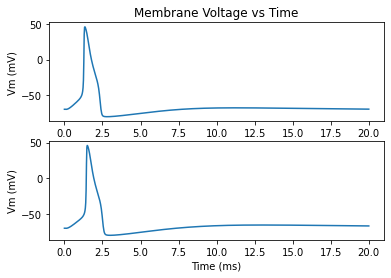

In [4]:
hf = h5py.File(paths.INVIVO_DATA_FILE, 'r')
groundtruth_lfp = np.array(hf.get('data'))
hf.close()

sim = Simulation(geometry = geo_standard, 
                 electrodes = params.ELECTRODE_POSITION, 
                 cell_type = CellTypes.ACTIVE, 
                 loc_param = loc_param, 
                 geo_param = geo_param,
                 spike_threshold = -20, 
                 gmax = gmax, 
                 scale = 1., 
                 ncell = number_samples)
# sim = Simulation(geo_standard,params.ELECTRODE_POSITION,loc_param,geo_param=geo_param,gmax=.001,scale=1000, ncell=ncell)  # gmax 0.001 -0.012
sec_list = sim.cells[0].all

filt_b,filt_a = signal.butter(params.BUTTERWORTH_ORDER,
                              params.FILTER_CRITICAL_FREQUENCY,
                              params.BANDFILTER_TYPE,
                              fs=params.FILTER_SAMPLING_RATE)

sim.run_neuron_sim()
print("Number of valid sample: %d" % (valid_count(sim)))
spike_times = sim.get_spike_time('all').reshape((number_samples, -1))
# print(spike_times)
sp_dict = {j+1: {i+1: spike_times[j,i] for i in range(spike_times.shape[1])} for j in range(spike_times.shape[0])}

# print(sp_dict)

import json
print(json.dumps(sp_dict, indent=2))

_ = plot_v(sim)

lfp = sim.get_lfp('all').T

filtered_lfp = signal.lfilter(filt_b,filt_a,lfp,axis=0) 

In [5]:
from cell_inference.utils.plotting.plot_results import plot_intracellular_spike_heatmap

vlim = 'auto'
# vlim = [-0.000005,0.000005]
ylim = [-1900,1900]

x_dist = np.unique(params.ELECTRODE_POSITION[:,0])
ix = 1
e_idx = ((params.ELECTRODE_POSITION[:,0]==x_dist[ix]) & 
         (params.ELECTRODE_POSITION[:,1]>=ylim[0]) & 
         (params.ELECTRODE_POSITION[:,1]<=ylim[1]))

membrane_voltage = sim.v('all').T
print(membrane_voltage.shape)
t = sim.t()

# fig,ax = plot_intracellular_spike_heatmap(t,
#                                           params.ELECTRODE_POSITION[e_idx, 1],
#                                           (membrane_voltage[:,:,i])[:][:, e_idx],
#                                           vlim=vlim,
#                                           fontsize=20,
#                                           labelpad=0,
#                                           ticksize=10,
#                                           nbins=5)

(801, 2)


Using column at x = -8 um
start: 10
end: 186
801


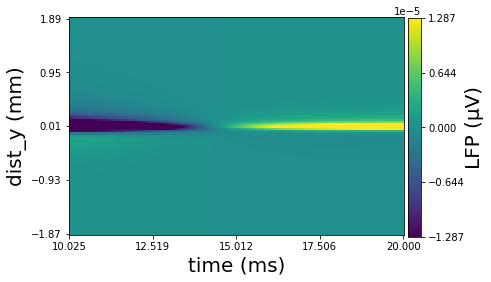

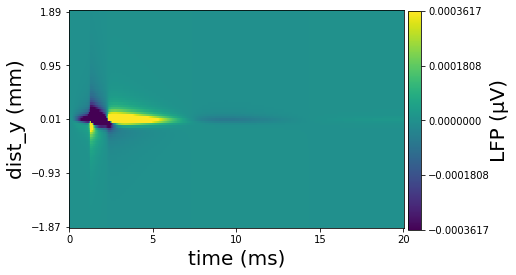

start: 10
end: 186
801


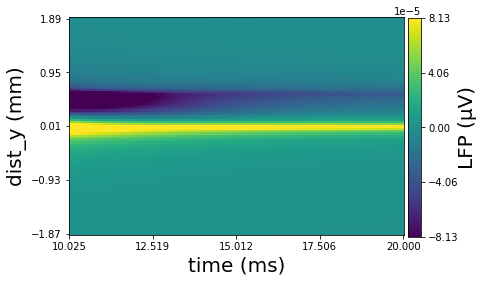

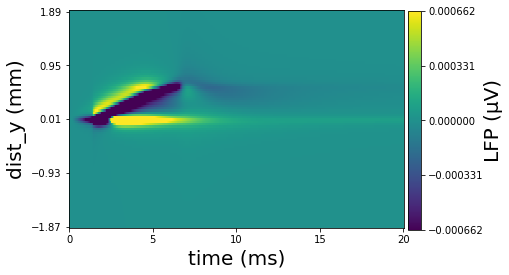

In [6]:
from cell_inference.utils.spike_window import first_pk_tr, get_spike_window

vlim = 'auto'
# vlim = [-0.000005,0.000005]
ylim = [-1900,1900]


t = sim.t()
x_dist = np.unique(params.ELECTRODE_POSITION[:,0])
ix = 1
e_idx = ((params.ELECTRODE_POSITION[:,0]==x_dist[ix]) & 
         (params.ELECTRODE_POSITION[:,1]>=ylim[0]) & 
         (params.ELECTRODE_POSITION[:,1]<=ylim[1]))

print('Using column at x = %g um' % (x_dist[ix]))

for i in range(lfp.shape[2]):
    fst_idx = first_pk_tr(np.squeeze(lfp[:,:,i]))
    start, end = get_spike_window(np.squeeze(lfp[:,:,i]), win_size=params.WINDOW_SIZE, align_at=fst_idx-10)
    print("start: {}\nend: {}".format(start, end))

    window = [start, end] #[0, 12]
    idx = (t>=window[0]) & (t<=window[1])  # time index
    print(len(idx))
    
    fig,ax = plot_lfp_heatmap(t[idx],params.ELECTRODE_POSITION[e_idx, 1],
                              (lfp[:,:,i])[idx][:, e_idx],vlim=vlim,
                              fontsize=20,labelpad=0,ticksize=10,nbins=5)

#     fig,ax = plot_lfp_heatmap(t[idx],params.ELECTRODE_POSITION[e_idx, 1],
#                               (filtered_lfp[:,:,i])[idx][:, e_idx],vlim=vlim,
#                               fontsize=20,labelpad=0,ticksize=10,nbins=5)
    
    fig,ax = plot_lfp_heatmap(t,params.ELECTRODE_POSITION[e_idx, 1],
                              (lfp[:,:,i])[:][:, e_idx],vlim=vlim,
                              fontsize=20,labelpad=0,ticksize=10,nbins=5)

#     fig,ax = plot_lfp_heatmap(t,params.ELECTRODE_POSITION[e_idx, 1],
#                               (filtered_lfp[:,:,i])[:][:, e_idx],vlim=vlim,
#                               fontsize=20,labelpad=0,ticksize=10,nbins=5)

In [7]:
from cell_inference.utils.feature_extractors.SummaryStats2D import build_lfp_grid, calculate_stats
from cell_inference.utils.spike_window import first_pk_tr, get_spike_window

summ_stats = []
for i in range(lfp.shape[2]):
    l = np.squeeze(lfp[:,:,i])
    fst_idx = first_pk_tr(l)
    start, end = get_spike_window(l, win_size=params.WINDOW_SIZE, align_at=fst_idx-10)
    g_lfp, grid = build_lfp_grid(l, params.ELECTRODE_POSITION, params.ELECTRODE_GRID)
    summ_stats.append(calculate_stats(g_lfp, grid))
summ_stats = np.stack(summ_stats, axis=-1)

In [8]:
labels = ["avg_mean",
            "avg_std",
            "avg_single_lfp_max_idx_x",
            "avg_single_lfp_max_idx_y",
            "avg_sing_lfp_max_val",
            "avg_single_lfp_min_idx_x",
            "avg_single_lfp_min_idx_y",
            "avg_single_lfp_min_val",
            "rel_t_mean",
            "rel_t_std",
            "rel_t_single_lfp_max_idx_x",
            "rel_t_single_lfp_max_idx_y",
            "rel_t_sing_lfp_max_val",
            "rel_t_single_lfp_min_idx_x",
            "rel_t_single_lfp_min_idx_y",
            "rel_t_single_lfp_min_val",
            "std_dev_mean",
            "std_dev_std",
            "std_dev_single_lfp_max_idx_y",
            "std_dev_single_lfp_max_idx_x",
            "std_dev_sing_lfp_max_val",
            "troughs_mean",
            "troughs_std",
            "troughs_single_lfp_max_idx_y",
            "troughs_single_lfp_max_idx_x",
            "troughs_sing_lfp_max_val",
            "peaks_mean",
            "peaks_std",
            "peaks_single_lfp_max_idx_y",
            "peaks_single_lfp_max_idx_x",
            "peaks_sing_lfp_max_val",
            "t0_idx_left",
            "t0_idx_right",
            "t1_idx_left",
            "t1_idx_right",
            "t2_idx_left",
            "t2_idx_right",
            "t0",
            "t1",
            "t2"
         ]

# for j in range(summ_stats.shape[1]):
dict_summ_stats = {j : {labels[i]: summ_stats[i,j] for i in range(len(labels))} for j in range(summ_stats.shape[1])}

In [9]:
import json
print(json.dumps(dict_summ_stats, indent=2))

{
  "0": {
    "avg_mean": -5.189039427356946e-07,
    "avg_std": 2.1069627526385577e-06,
    "avg_single_lfp_max_idx_x": 3.0,
    "avg_single_lfp_max_idx_y": 85.0,
    "avg_sing_lfp_max_val": 6.046828880596178e-07,
    "avg_single_lfp_min_idx_x": 1.0,
    "avg_single_lfp_min_idx_y": 95.0,
    "avg_single_lfp_min_val": -1.6228635140390583e-05,
    "rel_t_mean": 1.6723684210526315,
    "rel_t_std": 54.086741002627605,
    "rel_t_single_lfp_max_idx_x": 0.0,
    "rel_t_single_lfp_max_idx_y": 94.0,
    "rel_t_sing_lfp_max_val": 58.0,
    "rel_t_single_lfp_min_idx_x": 0.0,
    "rel_t_single_lfp_min_idx_y": 0.0,
    "rel_t_single_lfp_min_val": -54.0,
    "std_dev_mean": 3.4119551916565845e-05,
    "std_dev_std": 0.00010174093892315846,
    "std_dev_single_lfp_max_idx_y": 1.0,
    "std_dev_single_lfp_max_idx_x": 95.0,
    "std_dev_sing_lfp_max_val": 0.0007865824685628876,
    "troughs_mean": 0.00017675863853162406,
    "troughs_std": 0.0005626224448334031,
    "troughs_single_lfp_max_idx_y": 